In [1]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline # Dùng để đưa tất cả các process vào 1 pipeline
import pickle # để xuất file pkl
from sklearn.preprocessing import FunctionTransformer #Dùng để biến 1 hàm tự viết thành dạng sklearn và đưa vào pipeline
import numpy as np # Xử lí data 
import re # Xóa HTML
import os # Xử lí file
import pandas as pd # thư viện đọc file
import matplotlib.pyplot as plt # trực quan hoá
from bs4 import BeautifulSoup               # Dùng để xóa HTML
import nltk
cur_wkd = r'C:\Users\PC\Group-8-Project-Python\REVIEWSENTIMENT'
dir_path   = os.path.join(cur_wkd,'movie_data')               # thư mục chứa dữ liệu
train_path = os.path.join(dir_path, 'labeledTrainData.tsv')   # file train có nhãn
test_path  = os.path.join(dir_path, 'testData.tsv')           # file test không nhãn
unlabel_path = os.path.join(dir_path, 'unlabeledTrainData.tsv')  # file train không nhãn (dùng cho unsupervised nếu cần)
# TF-IDF Vectorizer của sklearn
train = pd.read_csv("movie_data/labeledTrainData.tsv", header=0, \
                    delimiter="\t", quoting=3)
test =  pd.read_csv("movie_data/testData.tsv", header=0, \
                    delimiter="\t", quoting=3)
# Header=0 cho biết dòng đầu tiên của tệp chứa tên cột;
# delimiter="\t" cho biết các trường được ngăn cách bằng ký tự tab;
# và quoting=3 yêu cầu Python bỏ qua các dấu ngoặc kép lặp (doubled quotes), tránh gặp lỗi khi đọc tệp.
train.shape


(25000, 3)

In [2]:
train.columns.values 

array(['id', 'sentiment', 'review'], dtype=object)

In [3]:
print(train["review"][0])

"With all this stuff going down at the moment with MJ i've started listening to his music, watching the odd documentary here and there, watched The Wiz and watched Moonwalker again. Maybe i just want to get a certain insight into this guy who i thought was really cool in the eighties just to maybe make up my mind whether he is guilty or innocent. Moonwalker is part biography, part feature film which i remember going to see at the cinema when it was originally released. Some of it has subtle messages about MJ's feeling towards the press and also the obvious message of drugs are bad m'kay.<br /><br />Visually impressive but of course this is all about Michael Jackson so unless you remotely like MJ in anyway then you are going to hate this and find it boring. Some may call MJ an egotist for consenting to the making of this movie BUT MJ and most of his fans would say that he made it for the fans which if true is really nice of him.<br /><br />The actual feature film bit when it finally sta

In [4]:
train.head()

,id,sentiment,review
0,"""5814_8""",1,"""With all this stuff going down at the moment ..."
1,"""2381_9""",1,"""\""The Classic War of the Worlds\"" by Timothy ..."
2,"""7759_3""",0,"""The film starts with a manager (Nicholas Bell..."
3,"""3630_4""",0,"""It must be assumed that those who praised thi..."
4,"""9495_8""",1,"""Superbly trashy and wondrously unpretentious ..."


In [5]:
test.head()

,id,review
0,"""12311_10""","""Naturally in a film who's main themes are of ..."
1,"""8348_2""","""This movie is a disaster within a disaster fi..."
2,"""5828_4""","""All in all, this is a movie for kids. We saw ..."
3,"""7186_2""","""Afraid of the Dark left me with the impressio..."
4,"""12128_7""","""A very accurate depiction of small time mob l..."


In [6]:
#############CLEANING DATA##################

#
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
stop_words = set(ENGLISH_STOP_WORDS)
# HÀM CLEANING 
def clean_text(text):
    # 2.1 Xóa HTML bằng BeautifulSoup (chính xác hơn Regex)
    text = BeautifulSoup(text, "html.parser").get_text()

    # 2.2 Xóa HTML còn sót lại bằng Regex (dự phòng)
    text = re.sub(r'<.*?>', '', text)

    # 2.3 Chuyển toàn bộ về chữ thường (lowercase)
    text = text.lower()

    # 2.4 Xóa ký tự đặc biệt, số, dấu câu — chỉ giữ lại chữ cái
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # 2.5 Xóa khoảng trắng dư thừa
    text = re.sub(r'\s+', ' ', text).strip()

    # 2.6 Xóa stopwords 
   # stopwords tiếng Anh 
    stop_words = set(ENGLISH_STOP_WORDS)

    # *** GIỮ LẠI CÁC TỪ PHỦ ĐỊNH ***
    neg_keep = {
        "not", "no", "nor", "never", "without",
        "n't",  # để giữ dạng don't/doesn't... nếu bạn giữ dấu '
        "cannot", "cant", "can't", "dont", "don't", "wont", "won't",
        "isnt", "isn't", "arent", "aren't", "wasnt", "wasn't",
        "werent", "weren't", "shouldnt", "shouldn't", "wouldnt", "wouldn't",
        "couldnt", "couldn't", "mustnt", "mustn't"
    }
    stop_words = stop_words.difference(neg_keep)

    # Lọc stopwords
    text = ' '.join([word for word in text.split() if word not in stop_words])
    # 2.7 Stemming (ví dụ running -> run, learners -> learn)
    stemmer = nltk.stem.SnowballStemmer('english')
    words = text.split()                     # <-- lấy token sau 2.6
    words = [stemmer.stem(w) for w in words] # <-- stem từng từ tiếng Anh
    text = ' '.join(words)                   # <-- ghép lại thành chuỗi
    return text



In [7]:
#Thêm clean review vào clean review
num_reviews = train["review"].size
clean_train_reviews = []
for i in range( 0, num_reviews ):
    clean_train_reviews.append( clean_text( train["review"][i] ) )

In [8]:
train["review"] = clean_train_reviews
train.head()

,id,sentiment,review
0,"""5814_8""",1,stuff go moment mj ive start listen music watc...
1,"""2381_9""",1,classic war world timothi hine entertain film ...
2,"""7759_3""",0,film start manag nichola bell give welcom inve...
3,"""3630_4""",0,assum prais film greatest film opera didnt rea...
4,"""9495_8""",1,superbl trashi wondrous unpretenti s exploit h...


In [9]:
# TIỀN XỬ LÝ TOÀN TẬP TRAIN/TEST # 
# Áp dụng clean cho từng review. 
# Ép về numpy array để tương thích scikit-learn.
train_data = []
for review in train.review:
    train_data.append(clean_text(review)) # xử lý từng review của tập train
train_data = np.array(train_data)


# Làm tương tự cho tập test
test_data = []
for review in test.review:
    test_data.append(clean_text(review))
test_data = np.array(test_data)

In [10]:
test_data

array(['natur film whos main theme mortal nostalgia loss innoc not surpris rate high older viewer younger one craftsmanship complet film enjoy pace steadi constant charact engag relationship interact natur show not need flood tear emot scream fear shout disput violenc anger natur joyc short stori lend film readi structur perfect polish diamond small chang huston make inclus poem fit neat truli masterpiec tact subtleti overwhelm beauti',
       'movi disast disast film great action scene meaning throw away sens realiti let word wise lava burn steam burn cant stand lava divert minor lava flow difficult let signific scare think actual believ saw movieeven wors signific talent went make film mean act actual good effect averag hard believ somebodi read script allow talent wast guess suggest movi start tv look away like train wreck aw know come just watch look away spend time meaning content',
       'movi kid saw tonight child love point kid excit great sit imposs great fan aa miln book sub

In [11]:
train_data

array(['stuff moment mj ive start listen music watch odd documentari watch wiz watch moonwalk mayb just want certain insight guy thought realli cool eighti just mayb make mind guilti innoc moonwalk biographi featur film rememb cinema origin relea subtl messag mjs feel press obvious messag drug bad mkayvisu impress cour michael jackson unless remot like mj hate bore mj egotist consent make movi mj fan say fan true realli nice himth actual featur film bit final start minut exclud smooth crimin sequenc joe pesci convinc psychopath power drug lord want mj dead bad mj overheard plan nah joe pesci charact rant want peopl know suppli drug dunno mayb just hate mjs musiclot cool thing like mj turn car robot speed demon sequenc director patienc saint came film kiddi bad sequenc usual director hate work kid let bunch perform complex danc scenebottom line movi peopl like mj level think peopl not stay away doe tri wholesom messag iron mjs bestest buddi movi girl michael jackson truli talent peopl g

In [12]:
print('Training Dim:', train_data.shape, 'Test Dim:', test_data.shape)

Training Dim: (25000,) Test Dim: (25000,)


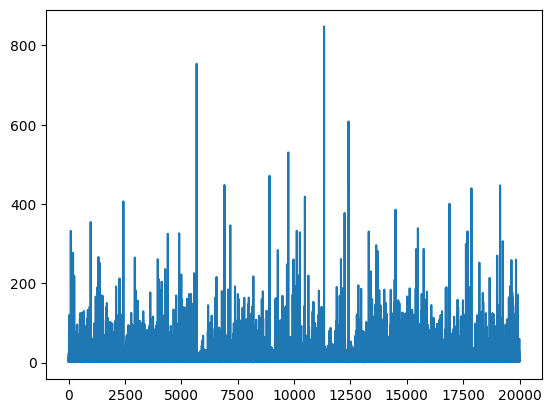

,term,tfidf
11328,movi,847.732832
5677,film,753.708622
12415,not,608.106800
9741,like,530.019592
8910,just,471.183472


In [13]:
# In[7]
# TF-IDF với sublinear_tf (1 + log(tf)) và cùng max_features
# - sublinear_tf=True giúp giảm ảnh hưởng của từ xuất hiện quá nhiều lần

tfidf_sub = TfidfVectorizer(
       ngram_range=(1, 3),
       use_idf=True,
       max_features=20000,
       sublinear_tf=True)

trainData_count_ltf = tfidf_sub.fit_transform(train_data)
testData_count_ltf  = tfidf_sub.transform(test_data)

# In[8]
# PHÂN TÍCH TRỌNG SỐ TF-IDF
# - Tạo DataFrame gồm (term, tổng tfidf trên toàn bộ train)
# - Vẽ phân phối tổng tfidf để tham khảo
# - Sắp xếp để xem term quan trọng nhất (theo tổng trọng số)
# Chú ý: .get_feature_names() đã deprecated ở sklearn mới -> dùng get_feature_names_out()
# Ở đây giữ như bản gốc; nếu chạy sklearn mới, bạn đổi sang get_feature_names_out().
# word_freq_df = pd.DataFrame({'term': tfidf.get_feature_names(), 'tfidf': trainData_count_tf.toarray().sum(axis=0)})
word_freq_df = pd.DataFrame({
    'term':  tfidf_sub.get_feature_names_out(),         # nếu lỗi, đổi thành tfidf_sub.get_feature_names_out()
    'tfidf': trainData_count_ltf.toarray().sum(axis=0)
})

# Vẽ nhanh biểu đồ tuyến tính của tổng tfidf theo chỉ số term
plt.plot(word_freq_df.tfidf)
plt.show()

# Sắp xếp giảm dần theo tổng tfidf
word_freq_df_sort = word_freq_df.sort_values(by=['tfidf'], ascending=False)
word_freq_df_sort.head()

In [14]:

from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV, StratifiedKFold, learning_curve
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

# Khởi tạo 5-fold CV có phân tầng
kfold = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)  # (sklearn mới khuyến nghị đặt shuffle=True)



In [15]:
# In[14]
# =============================================================================
# 4) LOGISTIC REGRESSION (LR)
# - Grid tham số: solver (sag/lbfgs/newton-cg), C (điều chuẩn L2), multi_class='multinomial'
# - scoring='roc_auc'
# Ghi chú bản gốc: best {'C': 4, 'multi_class': 'multinomial', 'penalty': 'l2', 'solver': 'sag'}, AUC ~0.9589
# =============================================================================
lr = LogisticRegression(random_state=2018)
lr_grid = {
    'solver': ['sag', 'lbfgs', 'newton-cg'],
    'C': [6, 4, 1, 0.5],
    'penalty': ['l2']
}

# dual chỉ dùng được với l2 ở solver 'liblinear'; phiên bản mới có thể kết hợp l1 với 'saga'
lr_cv = GridSearchCV(
    lr,
    param_grid=[lr_grid],
    cv=kfold,
    n_jobs=1,
    scoring='roc_auc'
)

lr_cv.fit(trainData_count_ltf, train["sentiment"])
print(lr_cv.best_score_)

0.958488448


In [16]:
# In[13]
# =============================================================================
# 3) Linear SVM (LinearSVC)
# - Grid tham số: C, loss='squared_hinge', penalty='l2', class_weight (ví dụ {1:4})
# - scoring='roc_auc'
# Lưu ý: LinearSVC không có predict_proba; GridSearchCV vẫn tính AUC dựa trên decision_function.
# =============================================================================
lsvc = LinearSVC(random_state=42)
lsvc_grid = {
    'C': [1, 0.2, 0.01],
    'loss': ['squared_hinge'],
    'penalty': ['l2'],
    'class_weight': [{1: 4}]
}

lsvc_cv = GridSearchCV(
    lsvc,
    param_grid=[lsvc_grid],
    verbose=1,
    cv=kfold,
    n_jobs=1,
    scoring='roc_auc'
)

lsvc_cv.fit(trainData_count_ltf, train["sentiment"])
print(lsvc_cv.best_score_)


Fitting 5 folds for each of 3 candidates, totalling 15 fits
0.957715712


In [17]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

rf = RandomForestClassifier(random_state=42, n_jobs=4)

param_dist = {"n_estimators": randint(80, 180),
              "max_depth": [None, 15, 25],
              "min_samples_split": [2, 5, 10],
              "min_samples_leaf": [1, 2, 4],
              "max_features": ["sqrt", 0.1]}

rf_cv = RandomizedSearchCV(rf, param_distributions=param_dist,
                           n_iter=20, # chỉ thử 20 tổ hợp
                           scoring="roc_auc", 
                           cv=3,  # ↓ từ 5 fold xuống 3 fold
                           verbose=1,
                           n_jobs=4,
                           random_state=42)

rf_cv.fit(trainData_count_ltf, train["sentiment"]) 

Fitting 3 folds for each of 20 candidates, totalling 60 fits


,estimator,RandomForestC...ndom_state=42)
,param_distributions,"{'max_depth': [None, 15, ...], 'max_features': ['sqrt', 0.1], 'min_samples_leaf': [1, 2, ...], 'min_samples_split': [2, 5, ...], ...}"
,n_iter,20
,scoring,'roc_auc'
,n_jobs,4
,refit,True
,cv,3
,verbose,1
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


In [18]:
def pick_best_model(return_gs: bool = True):
    """
    Trả về:
      - nếu return_gs=True: (model_name, best_gs, best_score)
        (best_gs là GridSearchCV đã fit có thể .predict() trực tiếp)
      - nếu return_gs=False: (model_name, best_estimator, best_score)
    Lưu ý: tất cả gs phải dùng cùng 'scoring'.
    """
    candidates = {
        "LR":   lr_cv,
        "RF":   rf_cv,
        "LSVC": lsvc_cv,
    }
    # lọc cái chưa khởi tạo/fit
    candidates = {k: v for k, v in candidates.items() if v is not None}

    # chọn theo best_score_
    best_name, best_gs = max(candidates.items(), key=lambda kv: kv[1].best_score_)
    best_score = best_gs.best_score_

    if return_gs:
        return best_name, best_gs, best_score        # ← trả về lr_cv/mnb_cv/... đúng như bạn muốn
    else:
        return best_name, best_gs.best_estimator_, best_score

In [19]:
name, model, score = pick_best_model()
def _clean_batch(X):
    # đảm bảo nhận iterable và trả về mảng object
    return np.array([clean_text(t) for t in X], dtype=object)
pred_mlp = model.predict(testData_count_ltf)
df = pd.DataFrame({'id': test.id, 'pred': pred_mlp})
pred_path = os.path.join(dir_path, 'FINAL.csv')
df.to_csv(pred_path, index=False, header=True)

In [20]:
# --- mapping tiện dùng ---
LABEL_TEXT = {0: "negative", 1: "positive"}
text_clf = Pipeline([
    ("clean_text", FunctionTransformer(_clean_batch, validate=False)),
    ("tfidf", tfidf_sub),   # phải là TfidfVectorizer đã fit (có vocabulary_)
    ("model", model)        # model đã fit
])
def predict_one(text: str):
    """Dự đoán cho 1 review, trả (label_text, score). 
    - score: nếu model có predict_proba -> xác suất lớp positive
             nếu không -> decision score (dương = thiên về positive)
    """
    X = [text]  # luôn gói 1 chuỗi thành list

    # 1) label
    y_pred = int(text_clf.predict(X)[0])
    label_text = LABEL_TEXT.get(y_pred, str(y_pred))

    # 2) score
    score = None
    if hasattr(text_clf, "predict_proba"):
        probs = text_clf.predict_proba(X)[0]
        # lấy xác suất của lớp "1" một cách an toàn theo classes_
        pos_idx = int(np.where(text_clf.classes_ == 1)[0][0])
        score = float(probs[pos_idx])
    elif hasattr(text_clf, "decision_function"):
        df = text_clf.decision_function(X)
        score = float(np.ravel(df)[0])  # >0 thiên về positive

    return label_text, score


In [21]:
text_clf.predict("This movie is bad")

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [22]:

def predict_batch(texts):
    # texts: list[str]
    y_pred = text_clf.predict(texts).astype(int)
    pred_label = [LABEL_TEXT.get(i, str(i)) for i in y_pred]

    # score: ưu tiên xác suất lớp 1 nếu có
    score = None
    if hasattr(text_clf, "predict_proba"):
        probs = text_clf.predict_proba(texts)
        pos_idx = int(np.where(text_clf.classes_ == 1)[0][0])
        score = probs[:, pos_idx].astype(float)
    elif hasattr(text_clf, "decision_function"):
        score = np.ravel(text_clf.decision_function(texts)).astype(float)

    df = pd.DataFrame({
        "review": texts,
        "pred_label": pred_label,
        "score": score if score is not None else np.nan
    })
    return df

In [23]:
predict_batch(["this movie is good", " this movie is bad"])

,review,pred_label,score
0,this movie is good,positive,0.950217
1,this movie is bad,negative,0.002340


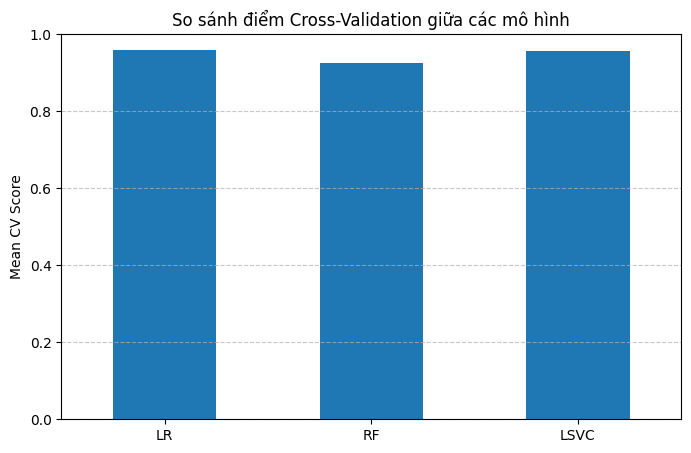

In [24]:
import matplotlib.pyplot as plt
import pandas as pd

models = {
    "LR": lr_cv,
    "RF": rf_cv,
    "LSVC": lsvc_cv
}

results = {
    name: {"Mean CV Score": gs.best_score_}
    for name, gs in models.items()
}

df = pd.DataFrame(results).T
df.plot(kind='bar', legend=False, figsize=(8,5))

plt.title("So sánh điểm Cross-Validation giữa các mô hình")
plt.ylabel("Mean CV Score")
plt.ylim(0, 1)
plt.xticks(rotation=0)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

# **Ý nghĩa của Cross-Validation (CV)**
*Cross-Validation (Kiểm tra chéo)* là một kỹ thuật thiết yếu trong học máy để đánh giá hiệu suất tổng quát của mô hình.
* Vấn đề nó giải quyết: Khi bạn huấn luyện một mô hình trên một tập dữ liệu (tập huấn luyện) và chỉ kiểm tra trên một tập dữ liệu khác (tập kiểm tra), kết quả có thể bị thiên vị (bias) và không phản ánh đúng khả năng hoạt động của mô hình trên dữ liệu mới, chưa từng thấy. Điều này gọi là quá khớp (Overfitting).
* Cách thức hoạt động (Thường là k-Fold CV):
    1. Tập dữ liệu được chia thành $k$ phần (hoặc "folds") có kích thước gần bằng nhau.
    2. Mô hình được huấn luyện $k$ lần. Trong mỗi lần, một phần được dùng làm tập kiểm tra và $k-1$ phần còn lại được dùng làm tập huấn luyện.
    3. $k$ điểm số hiệu suất (ví dụ: độ chính xác) được ghi lại.
    4. Điểm CV trung bình (Mean CV Score) chính là giá trị trung bình của $k$ điểm số này.
* Ý nghĩa của gs.best_score_: Đây là điểm số hiệu suất cao nhất mà mô hình đạt được trong quá trình tìm kiếm siêu tham số tối ưu (Grid Search - $gs$) thông qua Cross-Validation. Giá trị này là một ước tính đáng tin cậy về hiệu suất của mô hình trên dữ liệu độc lập.

In [25]:
# 1. Khai báo các metrics (thước đo)
scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'recall': 'recall',
    'f1_score': 'f1'
}

# 2. Áp dụng cho từng mô hình
from sklearn.model_selection import cross_validate

models = {
    "LR": LogisticRegression(random_state=42),
    "LSVC": LinearSVC(random_state=42),
    "RF": RandomForestClassifier(random_state=42)
}

results_metrics = {}

for name, model in models.items():
    # Sử dụng cross_validate để tính nhiều metrics trên mỗi fold
    cv_results = cross_validate(
        estimator=model,
        X=trainData_count_ltf, # Thay X bằng dữ liệu features của bạn
        y=train['sentiment'], # Thay y bằng dữ liệu labels của bạn
        cv=kfold, # Sử dụng StratifiedKFold đã khởi tạo
        scoring=scoring
    )
    
    # Lưu lại giá trị trung bình của từng metric
    results_metrics[name] = {
        'Accuracy': cv_results['test_accuracy'].mean(),
        'Precision': cv_results['test_precision'].mean(),
        'Recall': cv_results['test_recall'].mean(),
        'F1 Score': cv_results['test_f1_score'].mean()
    }

# 3. Tạo DataFrame để trực quan hóa
df_metrics = pd.DataFrame(results_metrics).T
print(df_metrics)

      Accuracy  Precision   Recall  F1 Score
LR     0.88732   0.878273  0.89936  0.888651
LSVC   0.88548   0.880012  0.89272  0.886289
RF     0.84428   0.846072  0.84168  0.843852


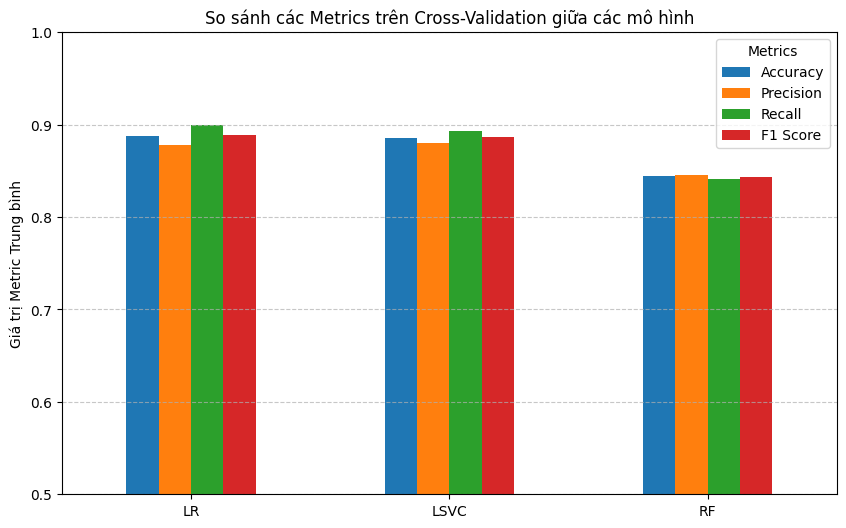

In [26]:
# Biểu đồ so sánh các metrics
fig, ax = plt.subplots(figsize=(10, 6))

# Vẽ biểu đồ cột nhóm
df_metrics.plot(kind='bar', ax=ax)

plt.title("So sánh các Metrics trên Cross-Validation giữa các mô hình")
plt.ylabel("Giá trị Metric Trung bình")
plt.ylim(0.5, 1) # Có thể điều chỉnh giới hạn trục Y
plt.xticks(rotation=0)
plt.legend(title="Metrics")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

# **Kết luận**
1. Mô hình Tốt nhất
LR và LSVC là những mô hình tốt nhất cho tập dữ liệu này. Cả hai đều đạt được hiệu suất cao nhất và cân bằng trên các metrics.
Có thể ưu tiên Logistic Regression (LR) vì nó thường huấn luyện nhanh hơn và dễ giải thích (interpretable) hơn so với LSVC, trong khi hiệu suất là tương đương.

2. Ý nghĩa của sự Cân bằng
Việc các metrics Accuracy, Precision, Recall, và F1 Score gần như bằng nhau ở cả ba mô hình (đặc biệt là LR và LSVC) cho thấy rằng mô hình có khả năng dự đoán chính xác và cân bằng giữa việc tránh lỗi dự đoán sai tiêu cực (Recall cao) và tránh lỗi dự đoán sai tích cực (Precision cao). Đây là dấu hiệu của một mô hình hoạt động tốt và ổn định.

3. Lý do RF thất bại
RF đạt điểm thấp nhất cho thấy dữ liệu có xu hướng tuyến tính hoặc có thể được phân tách hiệu quả bằng các mô hình tuyến tính, sự phức tạp của RF không mang lại lợi ích trên ma trận TF-IDF. Các mô hình tuyến tính đơn giản hơn đã đủ để tìm ra ranh giới phân lớp tối ưu.

In [28]:
with open("artifacts/textclf.pkl", "wb") as f:
    pickle.dump(text_clf, f)

# Tải
with open("artifacts/textclf.pkl", "rb") as f:
    text_clf = pickle.load(f)